In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import numpy as np
import math, copy, time
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
sns.set_context(context="talk")

import os, re, sys
import pandas as pd
import ast, time
import matplotlib.pyplot as plt
from numpy import linalg as LA
from sklearn.preprocessing import Normalizer
import re, io, nltk, torch 
from numpy.linalg import norm
from tqdm import tqdm, trange
from gensim import utils, matutils  # utility fnc for pickling, common scipy operations etc
from gensim.corpora.dictionary import Dictionary
from six import string_types, integer_types
from six.moves import zip, range
from scipy import stats
from gensim.utils import deprecated
from numpy import dot, float32 as REAL, memmap as np_memmap, \
    double, array, zeros, vstack, sqrt, newaxis, integer, \
    ndarray, sum as np_sum, prod, argmax
from collections import Counter
from scipy.spatial import distance
from numpy.random import binomial
from nltk.corpus import stopwords
from collections import Counter

from sklearn.utils import class_weight
from sklearn.preprocessing import normalize
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

import keras
from keras.callbacks import Callback,ModelCheckpoint, ReduceLROnPlateau    
from keras import backend as K
from keras.preprocessing import sequence
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Embedding
from keras.layers import Conv1D, Conv2D, MaxPooling1D, Input
from keras.models import Model
from keras.layers import LSTM,GRU,Dense
from keras.utils import Sequence,to_categorical
from keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.autograd import Variable


import transformers
from transformers import (
    WEIGHTS_NAME,
    AdamW,
    BertConfig,
    BertForMaskedLM,
    BertForSequenceClassification,
    BertTokenizer,
    CamembertConfig,
    CamembertForMaskedLM,
    CamembertTokenizer,
    DistilBertConfig,
    DistilBertForMaskedLM,
    DistilBertTokenizer,
    GPT2Config,
    GPT2LMHeadModel,
    GPT2Tokenizer,
    OpenAIGPTConfig,
    OpenAIGPTLMHeadModel,
    OpenAIGPTTokenizer,
    RobertaConfig,
    RobertaForMaskedLM,
    RobertaTokenizer,
    get_linear_schedule_with_warmup,
)

def focal_loss(gamma=2., weights=1):   #weights np.asarray()
    weights= K.variable(weights)
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.clip(y_true, K.epsilon(),1)
        y_pred = K.clip(y_pred,K.epsilon(),1)
        return - K.sum(weights* K.pow(1. - y_pred, gamma)* y_true * K.log(y_pred), axis=-1) 
    return focal_loss_fixed

class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []

    def on_epoch_end(self, batch, logs={}):
        prob = self.model.predict(self.validation_data[0])
        predict = np.squeeze(prob>=0.5)*1
        targ = np.squeeze(self.validation_data[1])
        f1s = f1_score(targ, predict,  average='macro')
        self.val_f1s.append(f1s)
        print(" - val_f1: ", f1s)
        return

def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    
def focal_loss(gamma=2., weights=1):   #weights np.asarray()
    weights= K.variable(weights)
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.clip(y_true, K.epsilon(),1)
        y_pred = K.clip(y_pred,K.epsilon(),1)
        return - K.sum(weights* K.pow(1. - y_pred, gamma)* y_true * K.log(y_pred), axis=-1) 
    return focal_loss_fixed

class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []

    def on_epoch_end(self, batch, logs={}):
        prob = self.model.predict(self.validation_data[0])
        predict = np.squeeze(prob>=0.5)*1
        targ = np.squeeze(self.validation_data[1])
        f1s = f1_score(targ, predict,  average='macro')
        self.val_f1s.append(f1s)
        print(" - val_f1: ", f1s)
        return

def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
        
stoplist = stopwords.words("english")

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
def my_cleaner(post):      
    s= re.sub(r"http\S+", "html", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', "hashtag", s) ########3
    s= re.sub(r'@\w+ ?', "user", s)##############    
    s= s.lower()    
    s=emoji_pattern.sub(r'', s)
    sl= list(s.split())  
    sl=[word for word in sl if word not in stoplist]
    s=' '.join([word for word in s.split() if word not in stoplist])
    return s, sl

def predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, name_model):
    etiq = etiq.astype("int")
    trainPredict = trained.predict(x_train, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq, trainPredict)  
    f1=f1_score(etiq, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq, trainPredict))
    print ("")
    print ("Accuracy sobre Train", name_model, ":",acc)  
    print ("F1-score None sobre Train", name_model, ":",f1)
    print ("F1-score macro sobre Train", name_model, ":",f1_ma)
    ########################################
    trainPredict = trained.predict(x_val, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq_v, trainPredict)  
    f1=f1_score(etiq_v, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq_v, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq_v, trainPredict))
    print ("")
    print ("Accuracy sobre Val", name_model, ":",acc)  
    print ("F1-score None sobre Val", name_model, ":",f1)
    print ("F1-score macro sobre Val", name_model, ":",f1_ma)
    ########################################
    trainPredict = trained.predict(x_test, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc_t= accuracy_score(etiq_t, trainPredict)  
    f1_t=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma_t=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    matriz_t=normalize(confusion_matrix(etiq_t, trainPredict))
    print ("")
    print ("Accuracy sobre Test", name_model, ":",acc_t)  
    print ("F1-score None sobre Test", name_model, ":",f1_t)
    print ("F1-score macro sobre Test", name_model, ":",f1_ma_t)
    
    return f1_ma_t, f1_t, acc_t, matriz_t

Using TensorFlow backend.


## Stance

In [2]:
train =pd.read_csv("../Fine-Tuning/CSV_Stance/train_semeval_raw.csv")
val=pd.read_csv("../Fine-Tuning/CSV_Stance/dev_semeval_raw.csv")
test=pd.read_csv("../Fine-Tuning/CSV_Stance/test_semeval_raw.csv")

print ("Conteo por stance\n", Counter(train['Label']))
train.head()

Conteo por stance
 Counter({'commenting': 2734, 'support': 841, 'denying': 333, 'questioning': 330})


,Tw_id,Tweet,Label
0,544296135180169216,@julia_goo_lia @BBCWorld clarified that earlie...,questioning
1,500454975185879040,@DostoevskyShade @AkaDimiX @140elect I think t...,commenting
2,553210433570881536,@PolicemansLot @Independent absolutely disgust...,commenting
3,553593015416008704,@HuffingtonPost Some good news!,support
4,500393155066626048,@andybankertv @FOX2now Any chance that's being...,questioning


In [3]:
dir_path='../../model_save/Dos-Fases-all_Stance/'
tokenizer_loaded = BertTokenizer.from_pretrained(dir_path)#'bert-base-uncased')
model_loaded = BertForSequenceClassification.from_pretrained(dir_path, num_labels=4)#'bert-base-uncased',  num_labels=4) 
idx_2_token = tokenizer_loaded.ids_to_tokens
archivo = open(dir_path+'vocab.txt','r')
Word2Index={word.strip():i for i,word in enumerate(archivo.readlines())}
M_BERT_space = model_loaded.bert.embeddings.word_embeddings.weight.detach().cpu().numpy()
transformer = Normalizer().fit(M_BERT_space) 
M_BERT_space=transformer.transform(M_BERT_space)

puntos='!?."()[´]“<>¡¿-/;:=_”@#.'


#sdqc
dict_cl=dict()
dict_cl[0]='support'
dict_cl[1]='denying'
dict_cl[2]='questioning'
dict_cl[3]='commenting'

#sdqc
d_lab=dict()
d_lab["support"]=0
d_lab["denying"]=1
d_lab["questioning"]=2
d_lab["commenting"]=3

#indice invertido para cada clase
tr_s=train.loc[train['Label']=='support']
tr_d=train.loc[train['Label']=='denying']
tr_q=train.loc[train['Label']=='questioning']
tr_c=train.loc[train['Label']=='commenting']

keys=['support', 'denying', 'questioning', 'commenting']

dict_clases={}
for key in keys: 
    tr_k=train.loc[train['Label']==key]
    tr_k=tr_k['Tweet'].values    
    trs_k=[]
    for tw in tr_k:
        encoded_sent = tokenizer_loaded.tokenize(my_cleaner(tw)[0])
        trs_k.append(encoded_sent)
    dict_clases[key]=trs_k  

dict_vocab={}
for key in keys: 
    lista=dict_clases[key]
    new_list=[]
    for tw in lista:
        new_list=new_list+tw
    print ("#terms ",key,":",len(new_list))
    dict_vocab[key]=new_list
      
vocabulary={}
for key in keys: 
    temp=list(set(dict_vocab[key]))
    print ("#Tweets",key,":",len(temp))
    vocabulary[key]=temp
    

dic_IdxI = {value: {} for value in d_lab.keys()}
for i, (muestra, label) in enumerate(list(zip(train['Tweet'],train['Label']))):
    pre=np.asarray(tokenizer_loaded.tokenize(my_cleaner(muestra)[0]))
    for token in pre:
        if token not in dic_IdxI[label]:
            dic_IdxI[label][token] = [i]
        else:
            dic_IdxI[label][token].append(i)
            
tags=['NN','NNS', 'JJ', 'JJR', 'JJS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
clases=['support', 'denying', 'questioning', 'commenting']
MAX_LEN = 50

def check_word(token, tag, clase):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        if nltk.pos_tag([token])[0][-1]==tag and token in vocabulary[clase]:
            return True
        else: 
            return False

def check_vocab(token, clase):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or  token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        if token in vocabulary[clase]:
            return True
        else: 
            return False
        
def check_tag(token, tag):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        if nltk.pos_tag([token])[0][-1]==tag:
            return True
        else: 
            return False
        
def check_vocab(token, clase):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        if token in vocabulary[clase]:
            return True
        else: 
            return False
            
def check_valid(lista, tags):
    keep=[]
    lista_tag= [nltk.pos_tag([wd])[0][-1] for wd in lista] 
    #print ("Tags de pos/neg:", lista_tag)
    for tag, word in list(zip(lista_tag , lista)):
        if tag in tags:
            keep.append(word)
    return keep

d_vocab=dict()
for clase in clases:
    d_vocab[clase]= [check_vocab(k, clase) for k in idx_2_token.values()]
    

#terms  support : 13504
#terms  denying : 4874
#terms  questioning : 4026
#terms  commenting : 37926
#Tweets support : 2442
#Tweets denying : 1628
#Tweets questioning : 1345
#Tweets commenting : 5270


In [5]:
etiq_v=[]
for et in val['Label'].values:
    etiq_v.append(d_lab[et])
n_labels_val = np.array(etiq_v)
y_val=to_categorical(n_labels_val,num_classes=4)
sentences_val = val['Tweet'].values
input_ids_val = []
for sent in sentences_val:
    encoded_sent = tokenizer_loaded.encode(my_cleaner(sent)[0],add_special_tokens = False)    
    input_ids_val.append(encoded_sent)
input_ids_val = pad_sequences(input_ids_val, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
shape_val=np.asarray(input_ids_val).shape
x_val=np.zeros((shape_val[0], shape_val[1], 768))
i=0
for in_id in input_ids_val:
    x_val[i]=M_BERT_space[in_id]
    i+=1
    
    
etiq_t=[]
for et in test['Label'].values:
    etiq_t.append(d_lab[et])
n_labels_test = np.array(etiq_t)
y_test=to_categorical(n_labels_test,num_classes=4)
sentences_test = test['Tweet'].values
input_ids_test = []
for sent in sentences_test:
    encoded_sent = tokenizer_loaded.encode(my_cleaner(sent)[0],add_special_tokens = False)    
    input_ids_test.append(encoded_sent)
input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
shape_test=np.asarray(input_ids_test).shape
x_test=np.zeros((shape_test[0], shape_test[1], 768))
i=0
for in_id in input_ids_test:
    x_test[i]=M_BERT_space[in_id]
    i+=1

x_test.shape

(1021, 50, 768)

##### LOADING TRAINING SET

In [7]:
macro_augmented=np.load('../Data_augmented/Stance_agregado/Sin_Aumento_1-run_0.0_balanced_w4_app1_Top1.npy', allow_pickle=True)
macro_augmented.shape

(4238, 3)

In [8]:
ids_train=macro_augmented[:,0]
tws_train=macro_augmented[:,1]
labels_train=macro_augmented[:,2]

etiq=labels_train.copy()
sentences = tws_train
n_labels = np.array(etiq)

input_ids = []
for sent in sentences:
    encoded_sent = tokenizer_loaded.encode(list(sent),add_special_tokens = False)    
    input_ids.append(encoded_sent)
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
y_train=to_categorical(n_labels,num_classes=4)
shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], shape[1], 768))
j=0
for in_id in input_ids:
    x_train[j]=M_BERT_space[in_id]
    j+=1

In [81]:
puntos='!?."()[´]“<>¡¿-/;:=_”@#.'

def new_just_tag_word(wd):
    #n_sentence=[]
    #for wd in sentence:
        if wd in puntos or wd[0]=='#':
            #i+=1
            #continue
            return False
        else:
            return True
            #n_sentence.append(wd)
    #return np.asarray(n_sentence), np.asarray(indices), np.asarray(valid)

def all_tag_word(wd):
    #n_sentence=[]
    #for wd in sentence:
        if wd in puntos: # or wd[0]=='#':
            #i+=1
            #continue
            return False
        else:
            return True
            #n_sentence.append(wd)
    #return np.asarray(n_sentence), np.asarray(indices), np.asarray(valid)
    
def all_tag_word2(token):
    #n_sentence=[]
    #for wd in sentence:
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or token in puntos or "##" in token or len(token) < 2: 
        #print ("El token k es eliminado es", token)
        return False#continue   
    else:
        return True#n_sentence.append(wd)
    #return np.asarray(n_sentence)
        
    
#sent, indices, tags = just_tag_word(muestra, tags_all, tag)

In [85]:
corpus_s_l=[]
corpus_d_l=[]
corpus_q_l=[]
corpus_c_l=[]
corpus_all_l=[]
antes=0
despues=f
print ("con un preprocesamiento a solo nivel de puntos...")
i=0
for tw in tws_train:#[:500]:
    cleaned=[]
    for wd in tw:        
        if all_tag_word(wd):
            cleaned.append(wd)

    if etiq[i]==0:
        corpus_s_l+=cleaned
    elif etiq[i]==1:
        corpus_d_l+=cleaned
    elif etiq[i]==2:
        corpus_q_l+=cleaned
    else:
        corpus_c_l+=cleaned
    corpus_all_l+=cleaned    
    despues+=len(cleaned)
    antes+=len(tw)
    i+=1

#print (corpus)
print ("MAXLEN antes promedio:", antes/len(tws_train))
print ("MAXLEN después promedio:", despues/len(tws_train))
print ("Tamaño del vocabulario Supporting:", len(set(corpus_s_l)))
print ("Tamaño del vocabulario Denying:", len(set(corpus_d_l)))
print ("Tamaño del vocabulario Questioning:", len(set(corpus_q_l)))
print ("Tamaño del vocabulario Commenting:", len(set(corpus_c_l)))
print ("Tamaño del vocabulario TOTAL:", len(set(corpus_all_l)))
print ("")

corpus_s_m=[]
corpus_d_m=[]
corpus_q_m=[]
corpus_c_m=[]
corpus_all_m=[]
antes=0
despues=f
print ("con un preprocesamiento a solo nivel de puntos y #...")
i=0
for tw in tws_train:
    cleaned=[]
    for wd in tw:        
        if new_just_tag_word(wd):
            cleaned.append(wd)

    if etiq[i]==0:
        corpus_s_m+=cleaned
    elif etiq[i]==1:
        corpus_d_m+=cleaned
    elif etiq[i]==2:
        corpus_q_m+=cleaned
    else:
        corpus_c_m+=cleaned
    corpus_all_m+=cleaned    
    despues+=len(cleaned)
    antes+=len(tw)
    i+=1

#print (corpus)
print ("MAXLEN antes promedio:", antes/len(tws_train))
print ("MAXLEN después promedio:", despues/len(tws_train))
print ("Tamaño del vocabulario Supporting:", len(set(corpus_s_m)))
print ("Tamaño del vocabulario Denying:", len(set(corpus_d_m)))
print ("Tamaño del vocabulario Questioning:", len(set(corpus_q_m)))
print ("Tamaño del vocabulario Commenting:", len(set(corpus_c_m)))
print ("Tamaño del vocabulario TOTAL:", len(set(corpus_all_m)))
print ("")

corpus_s=[]
corpus_d=[]
corpus_q=[]
corpus_c=[]
corpus_all=[]
antes=0
despues=f
print ("con un preprocesamiento a nivel de #, puntos, numbers y len mayor a 2...")
i=0
for tw in tws_train:
    #print ("antes:")
    #print (tw)    
    cleaned=[]
    for wd in tw:        
        if all_tag_word2(wd):
            cleaned.append(wd)

    if etiq[i]==0:
        corpus_s+=cleaned
    elif etiq[i]==1:
        corpus_d+=cleaned
    elif etiq[i]==2:
        corpus_q+=cleaned
    else:
        corpus_c+=cleaned
    #print ("despues:")
    #print (cleaned)
    corpus_all+=cleaned    
    despues+=len(cleaned)
    antes+=len(tw)
    i+=1

#print (corpus)
print ("MAXLEN antes promedio:", antes/len(tws_train))
print ("MAXLEN después promedio:", despues/len(tws_train))
print ("Tamaño del vocabulario Supporting:", len(set(corpus_s)))
print ("Tamaño del vocabulario Denying:", len(set(corpus_d)))
print ("Tamaño del vocabulario Questioning:", len(set(corpus_q)))
print ("Tamaño del vocabulario Commenting:", len(set(corpus_c)))
print ("Tamaño del vocabulario TOTAL:", len(set(corpus_all)))
print ("")


con un preprocesamiento a solo nivel de puntos...
MAXLEN antes promedio: 14.235488437942426
MAXLEN después promedio: 12.182633317602642
Tamaño del vocabulario Supporting: 2426
Tamaño del vocabulario Denying: 1615
Tamaño del vocabulario Questioning: 1332
Tamaño del vocabulario Commenting: 5255
Tamaño del vocabulario TOTAL: 6221

con un preprocesamiento a solo nivel de puntos y #...
MAXLEN antes promedio: 14.235488437942426
MAXLEN después promedio: 8.827748938178386
Tamaño del vocabulario Supporting: 1870
Tamaño del vocabulario Denying: 1247
Tamaño del vocabulario Questioning: 1016
Tamaño del vocabulario Commenting: 4033
Tamaño del vocabulario TOTAL: 4767

con un preprocesamiento a nivel de #, puntos, numbers y len mayor a 2...
MAXLEN antes promedio: 14.235488437942426
MAXLEN después promedio: 7.869042000943842
Tamaño del vocabulario Supporting: 1801
Tamaño del vocabulario Denying: 1196
Tamaño del vocabulario Questioning: 979
Tamaño del vocabulario Commenting: 3923
Tamaño del vocabulario

In [95]:
x_test_wd=[]
for sent in input_ids_test:
    temp=[]
    for idx in sent:
        if idx!=0:
            temp.append(idx_2_token[idx])
    x_test_wd.append(temp)  

x_val_wd=[]
for sent in input_ids_val:
    temp=[]
    for idx in sent:
        if idx!=0:
            temp.append(idx_2_token[idx])
    x_val_wd.append(temp)  

In [104]:
t_corpus_s_m=[]
t_corpus_d_m=[]
t_corpus_q_m=[]
t_corpus_c_m=[]
t_corpus_all_m=[]
antes=0
despues=f
print ("TESTING con un preprocesamiento a solo nivel de puntos y #...")
i=0
for tw in x_test_wd:
    cleaned=[]
    for wd in tw:        
        if new_just_tag_word(wd):
            cleaned.append(wd)

    if etiq[i]==0:
        t_corpus_s_m+=cleaned
    elif etiq[i]==1:
        t_corpus_d_m+=cleaned
    elif etiq[i]==2:
        t_corpus_q_m+=cleaned
    else:
        t_corpus_c_m+=cleaned
    t_corpus_all_m+=cleaned    
    despues+=len(cleaned)
    antes+=len(tw)
    i+=1

#print (corpus)
print ("MAXLEN antes promedio:", antes/len(x_test_wd))
print ("MAXLEN después promedio:", despues/len(x_test_wd))
print ("Tamaño del vocabulario Supporting:", len(set(t_corpus_s_m)))
print ("Tamaño del vocabulario Denying:", len(set(t_corpus_d_m)))
print ("Tamaño del vocabulario Questioning:", len(set(t_corpus_q_m)))
print ("Tamaño del vocabulario Commenting:", len(set(t_corpus_c_m)))
print ("Tamaño del vocabulario TOTAL:", len(set(t_corpus_all_m)))
print ("")

t_corpus_s=[]
t_corpus_d=[]
t_corpus_q=[]
t_corpus_c=[]
t_corpus_all=[]
antes=0
despues=f
print ("TESTING con un preprocesamiento a nivel de #, puntos, numbers y len mayor a 2...")
i=0
for tw in x_test_wd:
    #print ("antes:")
    #print (tw)    
    cleaned=[]
    for wd in tw:        
        if all_tag_word2(wd):
            cleaned.append(wd)

    if etiq[i]==0:
        t_corpus_s+=cleaned
    elif etiq[i]==1:
        t_corpus_d+=cleaned
    elif etiq[i]==2:
        t_corpus_q+=cleaned
    else:
        t_corpus_c+=cleaned
    #print ("despues:")
    #print (cleaned)
    t_corpus_all+=cleaned    
    despues+=len(cleaned)
    antes+=len(tw)
    i+=1

#print (corpus)
print ("MAXLEN antes promedio:", antes/len(x_test_wd))
print ("MAXLEN después promedio:", despues/len(x_test_wd))
print ("Tamaño del vocabulario Supporting:", len(set(t_corpus_s)))
print ("Tamaño del vocabulario Denying:", len(set(t_corpus_d)))
print ("Tamaño del vocabulario Questioning:", len(set(t_corpus_q)))
print ("Tamaño del vocabulario Commenting:", len(set(t_corpus_c)))
print ("Tamaño del vocabulario TOTAL:", len(set(t_corpus_all)))
print ("")


TESTING con un preprocesamiento a solo nivel de puntos y #...
MAXLEN antes promedio: 13.725759059745348
MAXLEN después promedio: 8.444662095984329
Tamaño del vocabulario Supporting: 897
Tamaño del vocabulario Denying: 382
Tamaño del vocabulario Questioning: 301
Tamaño del vocabulario Commenting: 1909
Tamaño del vocabulario TOTAL: 2396

TESTING con un preprocesamiento a nivel de #, puntos, numbers y len mayor a 2...
MAXLEN antes promedio: 13.725759059745348
MAXLEN después promedio: 7.537708129285015
Tamaño del vocabulario Supporting: 860
Tamaño del vocabulario Denying: 365
Tamaño del vocabulario Questioning: 281
Tamaño del vocabulario Commenting: 1842
Tamaño del vocabulario TOTAL: 2317



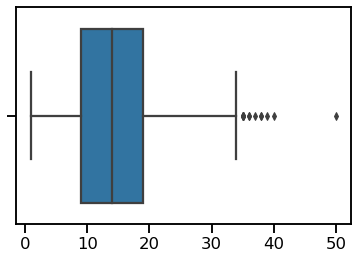

In [107]:
lens=[]
for sent in input_ids:
    largo=0
    for wd in sent:
        if wd!=0:
            largo+=1
    lens.append(largo)
    
sns.boxplot(lens)

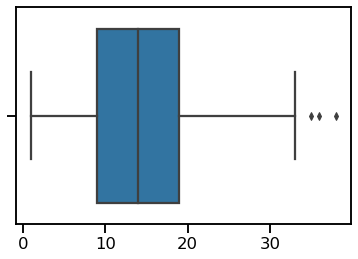

In [105]:
lens=[]
for sent in input_ids_val:
    largo=0
    for wd in sent:
        if wd!=0:
            largo+=1
    lens.append(largo)
    
sns.boxplot(lens)

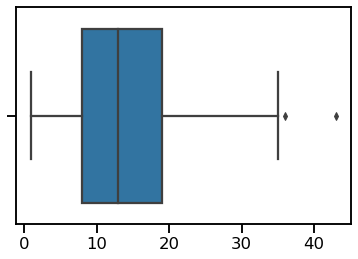

In [106]:
lens=[]
for sent in input_ids_test:
    largo=0
    for wd in sent:
        if wd!=0:
            largo+=1
    lens.append(largo)
    
sns.boxplot(lens)

In [125]:
s_in_trainNtest=set(corpus_s)-set(t_corpus_s)
s_in_testNtrain=set(t_corpus_s)-set(corpus_s)
print ("Para Supporting hay...")
print ("Training:", len(set(corpus_s)))
print ("Testing:", len(set(t_corpus_s)))
print ("Existen ",len(s_in_trainNtest),"términos en training que no están en Testing")
print ("Existen ",len(s_in_testNtrain),"términos en Testing que no están en training")
print ('')
d_in_trainNtest=set(corpus_d)-set(t_corpus_d)
d_in_testNtrain=set(t_corpus_d)-set(corpus_d)
print ("Para Denying hay...")
print ("Training:", len(set(corpus_d)))
print ("Testing:", len(set(t_corpus_d)))
print ("Existen ",len(d_in_trainNtest),"términos en training que no están en Testing")
print ("Existen ",len(d_in_testNtrain),"términos en Testing que no están en training")
print ('')
q_in_trainNtest=set(corpus_q)-set(t_corpus_q)
q_in_testNtrain=set(t_corpus_q)-set(corpus_q)
print ("Para Questioning hay...")
print ("Training:", len(set(corpus_q)))
print ("Testing:", len(set(t_corpus_q)))
print ("Existen ",len(q_in_trainNtest),"términos en training que no están en Testing")
print ("Existen ",len(q_in_testNtrain),"términos en Testing que no están en training")
print ('')
c_in_trainNtest=set(corpus_c)-set(t_corpus_c)
c_in_testNtrain=set(t_corpus_c)-set(corpus_c)
print ("Para Commenting hay...")
print ("Training:", len(set(corpus_c)))
print ("Testing:", len(set(t_corpus_c)))
print ("Existen ",len(c_in_trainNtest),"términos en training que no están en Testing")
print ("Existen ",len(c_in_testNtrain),"términos en Testing que no están en training")

Para Supporting hay...
Training: 1801
Testing: 860
Existen  1334 términos en training que no están en Testing
Existen  393 términos en Testing que no están en training

Para Denying hay...
Training: 1196
Testing: 365
Existen  1030 términos en training que no están en Testing
Existen  199 términos en Testing que no están en training

Para Questioning hay...
Training: 979
Testing: 281
Existen  839 términos en training que no están en Testing
Existen  141 términos en Testing que no están en training

Para Commenting hay...
Training: 3923
Testing: 1842
Existen  2649 términos en training que no están en Testing
Existen  568 términos en Testing que no están en training


##### VISUALIZACION

In [147]:
def visualize_dims(data, labels, clase):    
    mask_a = (labels=="Train")
    mask_b = (labels=="Test") 
    model = KernelPCA(2, kernel='rbf', gamma=0.01, n_jobs=-1)  #linear” | “poly” | “rbf” 
    to_plot_kpca = model.fit_transform(data)    
    
    plt.figure(figsize=(10,7))
    plt.scatter(to_plot_kpca[:,0][mask_a],to_plot_kpca[:,1][mask_a], label="Train")
    plt.scatter(to_plot_kpca[:,0][mask_b],to_plot_kpca[:,1][mask_b], label="Test")
    
    plt.legend()
    plt.title("Vocabulario Clase "+str(clase))
    plt.show()

    return to_plot_kpca

def visualize_dims_tsne(data, labels, clase):
    mask_a = (labels=="Train")
    mask_b = (labels=="Test") 
    model = TSNE(2, metric='euclidean')
    to_plot_tsne = model.fit_transform(data)   
    
    plt.figure(figsize=(10,7))
    plt.scatter(to_plot_tsne[:,0][mask_a],to_plot_tsne[:,1][mask_a], label="Train")
    plt.scatter(to_plot_tsne[:,0][mask_b],to_plot_tsne[:,1][mask_b], label="Test")
    
    plt.legend()
    plt.title("Vocabulario T-SNE Clase "+str(clase))
    plt.show()

    return to_plot_tsne


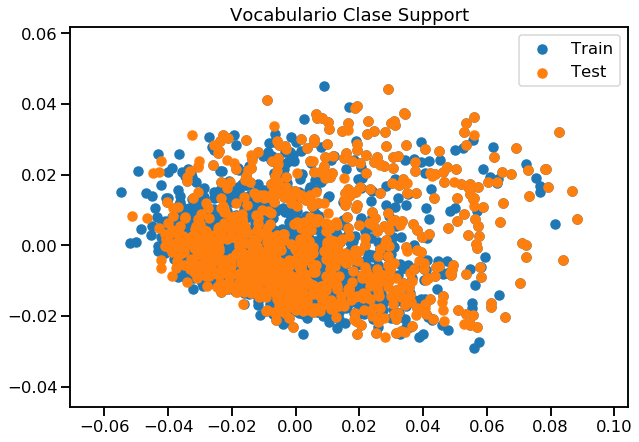

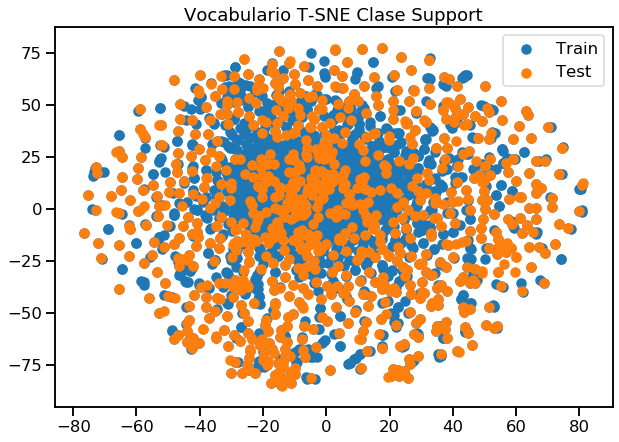

In [150]:
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE 


clase=["Train"]
labels1 = clase*len(set(corpus_s))
corpus_temp=list(set(corpus_s))
data1=[M_BERT_space[Word2Index[wd]] for wd in corpus_temp]
clase=["Test"]
labels2 = clase*len(set(t_corpus_s))
corpus_temp=list(set(t_corpus_s))
data2=[M_BERT_space[Word2Index[wd]] for wd in corpus_temp]
data=data1+data2
labels=labels1+labels2

to_plot_kpca = visualize_dims(data, np.asarray(labels), 'Support')
to_plot_tsne = visualize_dims_tsne(data, np.asarray(labels), 'Support')

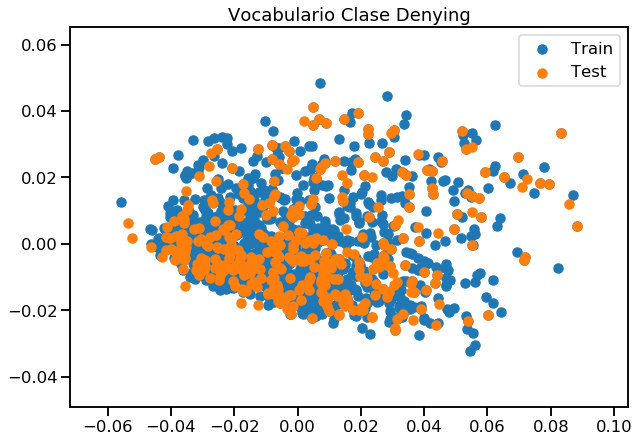

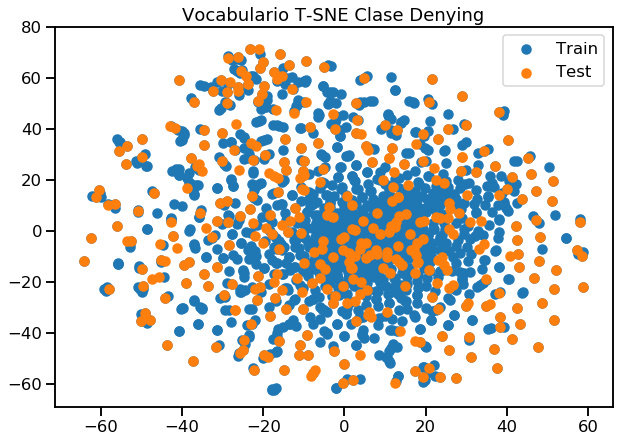

In [151]:
clase=["Train"]
labels1 = clase*len(set(corpus_d))
corpus_temp=list(set(corpus_d))
data1=[M_BERT_space[Word2Index[wd]] for wd in corpus_temp]
clase=["Test"]
labels2 = clase*len(set(t_corpus_d))
corpus_temp=list(set(t_corpus_d))
data2=[M_BERT_space[Word2Index[wd]] for wd in corpus_temp]
data=data1+data2
labels=labels1+labels2

to_plot_kpca = visualize_dims(data, np.asarray(labels), 'Denying')
to_plot_tsne = visualize_dims_tsne(data, np.asarray(labels), 'Denying')

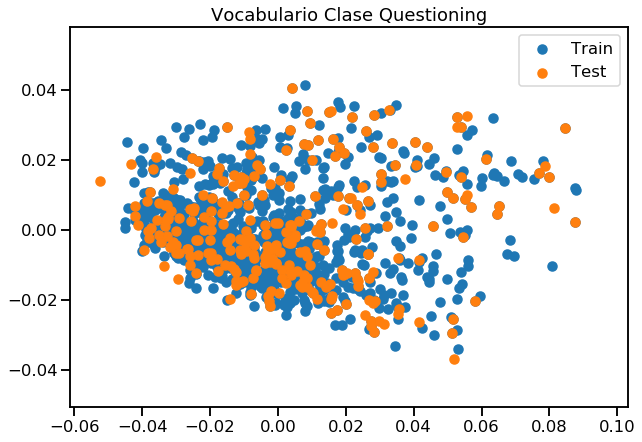

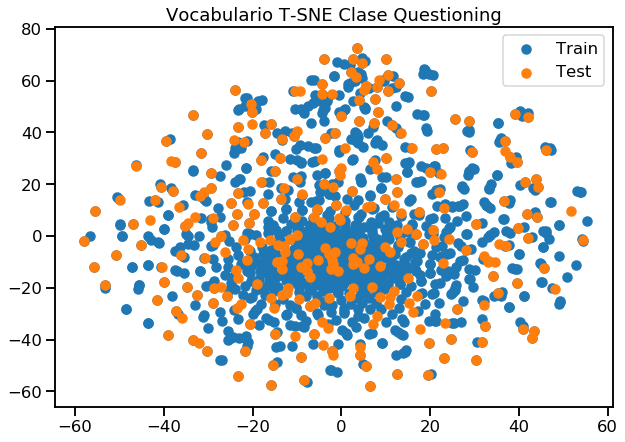

In [152]:
clase=["Train"]
labels1 = clase*len(set(corpus_q))
corpus_temp=list(set(corpus_q))
data1=[M_BERT_space[Word2Index[wd]] for wd in corpus_temp]
clase=["Test"]
labels2 = clase*len(set(t_corpus_q))
corpus_temp=list(set(t_corpus_q))
data2=[M_BERT_space[Word2Index[wd]] for wd in corpus_temp]
data=data1+data2
labels=labels1+labels2

to_plot_kpca = visualize_dims(data, np.asarray(labels), 'Questioning')
to_plot_tsne = visualize_dims_tsne(data, np.asarray(labels), 'Questioning')

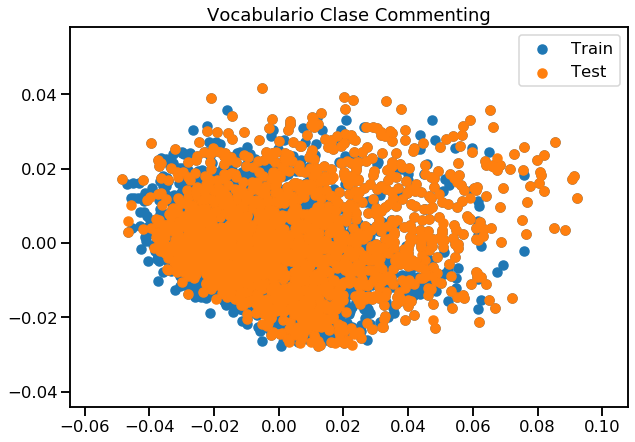

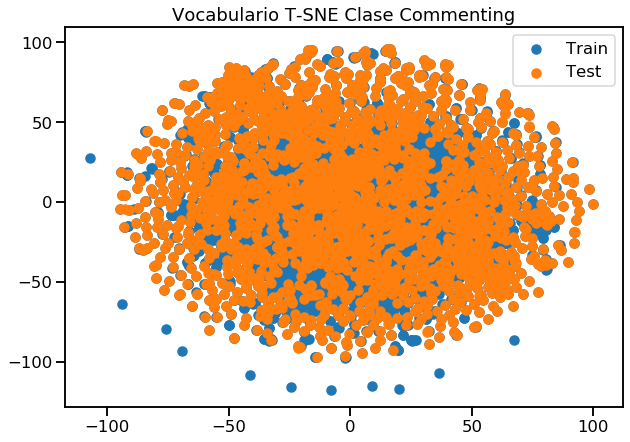

In [153]:
clase=["Train"]
labels1 = clase*len(set(corpus_c))
corpus_temp=list(set(corpus_c))
data1=[M_BERT_space[Word2Index[wd]] for wd in corpus_temp]
clase=["Test"]
labels2 = clase*len(set(t_corpus_c))
corpus_temp=list(set(t_corpus_c))
data2=[M_BERT_space[Word2Index[wd]] for wd in corpus_temp]
data=data1+data2
labels=labels1+labels2

to_plot_kpca = visualize_dims(data, np.asarray(labels), 'Commenting')
to_plot_tsne = visualize_dims_tsne(data, np.asarray(labels), 'Commenting')

## Harassment

In [155]:
train=pd.read_csv("../Fine-Tuning/CSV_Harassment/train_format.csv")
val=pd.read_csv("../Fine-Tuning/CSV_Harassment/val_format.csv")
test=pd.read_csv("../Fine-Tuning/CSV_Harassment/test_format.csv")

dir_path='../../model_save/Dos-Fases-all_Harassment/'
tokenizer_loaded = BertTokenizer.from_pretrained(dir_path)#'bert-base-uncased')
model_loaded = BertForSequenceClassification.from_pretrained(dir_path, num_labels=4)#'bert-base-uncased',  num_labels=4) 
idx_2_token = tokenizer_loaded.ids_to_tokens
archivo = open(dir_path+'vocab.txt','r')
Word2Index={word.strip():i for i,word in enumerate(archivo.readlines())}
M_BERT_space = model_loaded.bert.embeddings.word_embeddings.weight.detach().cpu().numpy()
transformer = Normalizer().fit(M_BERT_space) 
M_BERT_space=transformer.transform(M_BERT_space)

puntos='!?."()[´]“<>¡¿-/;:=_”@#.'


dict_cl=dict()
dict_cl[0]="NonH"
dict_cl[1]="IndirectH"
dict_cl[2]="PhysicalH"
dict_cl[3]="SexualH"

#sdqc
d_lab=dict()
d_lab["NonH"]=0
d_lab["IndirectH"]=1
d_lab["PhysicalH"]=2
d_lab["SexualH"]=3

#etiq=[dict_cl[y] for y in y_train]
etiq_v=[d_lab[y] for y in val['Label']]
etiq_t=[d_lab[y] for y in test['Label']]

#indice invertido para cada clase
tr_s=train.loc[train['Label']=='NonH']
tr_d=train.loc[train['Label']=='IndirectH']
tr_q=train.loc[train['Label']=='PhysicalH']
tr_c=train.loc[train['Label']=='SexualH']

keys=['NonH', 'IndirectH', 'PhysicalH', 'SexualH']

dict_clases={}
for key in keys: 
    tr_k=train[train['Label']==key]['Tweet']
    trs_k=[]
    for tw in tr_k:
        encoded_sent = tokenizer_loaded.tokenize(my_cleaner(tw)[0])
        trs_k.append(encoded_sent)
    dict_clases[key]=trs_k  

dict_vocab={}
for key in keys: 
    lista=dict_clases[key]
    new_list=[]
    for tw in lista:
        new_list=new_list+tw
    print ("#terms ",key,":",len(new_list))
    dict_vocab[key]=new_list
      
vocabulary={}
for key in keys: 
    temp=list(set(dict_vocab[key]))
    print ("#Tweets",key,":",len(temp))
    vocabulary[key]=temp
    

dic_IdxI = {value: {} for value in d_lab.keys()}
for i, (muestra, label) in enumerate(list(zip(train['Tweet'],train['Label']))):
    pre=np.asarray(tokenizer_loaded.tokenize(my_cleaner(muestra)[0]))
    for token in pre:
        if token not in dic_IdxI[label]:
            dic_IdxI[label][token] = [i]
        else:
            dic_IdxI[label][token].append(i)
            


#terms  NonH : 67202
#terms  IndirectH : 897
#terms  PhysicalH : 1265
#terms  SexualH : 49711
#Tweets NonH : 9467
#Tweets IndirectH : 577
#Tweets PhysicalH : 755
#Tweets SexualH : 6386


In [156]:
tags=['NN','NNS', 'JJ', 'JJR', 'JJS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
clases=['NonH', 'IndirectH', 'PhysicalH', 'SexualH']
MAX_LEN = 50

d_pos= dict()
for tag in tags:
    d_pos[tag]= [check_tag(k, tag) for k in idx_2_token.values()]
    
d_vocab=dict()
for clase in clases:
    d_vocab[clase]= [check_vocab(k, clase) for k in idx_2_token.values()]
    

n_labels_val = np.array(etiq_v)
y_val=to_categorical(n_labels_val,num_classes=4)
sentences_val = val['Tweet'].values
input_ids_val = []
for sent in sentences_val:
    encoded_sent = tokenizer_loaded.encode(my_cleaner(sent)[0],add_special_tokens = False)    
    input_ids_val.append(encoded_sent)
input_ids_val = pad_sequences(input_ids_val, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")


n_labels_test = np.array(etiq_t)
y_test=to_categorical(n_labels_test,num_classes=4)
sentences_test = test['Tweet'].values
input_ids_test = []
for sent in sentences_test:
    encoded_sent = tokenizer_loaded.encode(my_cleaner(sent)[0],add_special_tokens = False)    
    input_ids_test.append(encoded_sent)
input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")


In [157]:
shape_val=np.asarray(input_ids_val).shape
x_val=np.zeros((shape_val[0], shape_val[1], 768))
i=0
for in_id in input_ids_val:
    x_val[i]=M_BERT_space[in_id]
    i+=1
    
shape_test=np.asarray(input_ids_test).shape
x_test=np.zeros((shape_test[0], shape_test[1], 768))
i=0
for in_id in input_ids_test:
    x_test[i]=M_BERT_space[in_id]
    i+=1

x_test.shape

(2123, 50, 768)

##### LOADING TRAINING SET

In [158]:
macro_augmented=np.load('../Data_augmented/Harassment_agregado/Sin_Aumento_1-run_0.0_balanced_w4_app1_Top1.npy', allow_pickle=True)
macro_augmented.shape

(6374, 3)

In [159]:
ids_train=macro_augmented[:,0]
tws_train=macro_augmented[:,1]
labels_train=macro_augmented[:,2]

etiq=labels_train.copy()
sentences = tws_train
n_labels = np.array(etiq)

input_ids = []
for sent in sentences:
    encoded_sent = tokenizer_loaded.encode(list(sent),add_special_tokens = False)    
    input_ids.append(encoded_sent)
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
y_train=to_categorical(n_labels,num_classes=4)
shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], shape[1], 768))
j=0
for in_id in input_ids:
    x_train[j]=M_BERT_space[in_id]
    j+=1

In [160]:
corpus_n_m=[]
corpus_i_m=[]
corpus_p_m=[]
corpus_s_m=[]
corpus_all_m=[]
antes=0
despues=f
print ("con un preprocesamiento a solo nivel de puntos y #...")
i=0
for tw in tws_train:
    cleaned=[]
    for wd in tw:        
        if new_just_tag_word(wd):
            cleaned.append(wd)

    if etiq[i]==0:
        corpus_n_m+=cleaned
    elif etiq[i]==1:
        corpus_i_m+=cleaned
    elif etiq[i]==2:
        corpus_p_m+=cleaned
    else:
        corpus_s_m+=cleaned
    corpus_all_m+=cleaned    
    despues+=len(cleaned)
    antes+=len(tw)
    i+=1

#print (corpus)
print ("MAXLEN antes promedio:", antes/len(tws_train))
print ("MAXLEN después promedio:", despues/len(tws_train))
print ("Tamaño del vocabulario NonH:", len(set(corpus_n_m)))
print ("Tamaño del vocabulario IndirectH:", len(set(corpus_i_m)))
print ("Tamaño del vocabulario PhysicalH:", len(set(corpus_p_m)))
print ("Tamaño del vocabulario SexualH:", len(set(corpus_s_m)))
print ("Tamaño del vocabulario TOTAL:", len(set(corpus_all_m)))
print ("")

corpus_n=[]
corpus_i=[]
corpus_p=[]
corpus_s=[]
corpus_all=[]
antes=0
despues=f
print ("con un preprocesamiento a nivel de #, puntos, numbers y len mayor a 2...")
i=0
for tw in tws_train:
    #print ("antes:")
    #print (tw)    
    cleaned=[]
    for wd in tw:        
        if all_tag_word2(wd):
            cleaned.append(wd)

    if etiq[i]==0:
        corpus_n+=cleaned
    elif etiq[i]==1:
        corpus_i+=cleaned
    elif etiq[i]==2:
        corpus_p+=cleaned
    else:
        corpus_s+=cleaned
    #print ("despues:")
    #print (cleaned)
    corpus_all+=cleaned    
    despues+=len(cleaned)
    antes+=len(tw)
    i+=1

#print (corpus)
print ("MAXLEN antes promedio:", antes/len(tws_train))
print ("MAXLEN después promedio:", despues/len(tws_train))
print ("Tamaño del vocabulario Non-H:", len(set(corpus_n)))
print ("Tamaño del vocabulario IndirectH:", len(set(corpus_i)))
print ("Tamaño del vocabulario PhysicalH:", len(set(corpus_p)))
print ("Tamaño del vocabulario SexualH:", len(set(corpus_s)))
print ("Tamaño del vocabulario TOTAL:", len(set(corpus_all)))
print ("")


con un preprocesamiento a solo nivel de puntos y #...
MAXLEN antes promedio: 18.68136178224035
MAXLEN después promedio: 11.257138374647003
Tamaño del vocabulario NonH: 6964
Tamaño del vocabulario IndirectH: 372
Tamaño del vocabulario PhysicalH: 525
Tamaño del vocabulario SexualH: 4458
Tamaño del vocabulario TOTAL: 8244

con un preprocesamiento a nivel de #, puntos, numbers y len mayor a 2...
MAXLEN antes promedio: 18.68136178224035
MAXLEN después promedio: 10.059460307499215
Tamaño del vocabulario Non-H: 6784
Tamaño del vocabulario IndirectH: 353
Tamaño del vocabulario PhysicalH: 505
Tamaño del vocabulario SexualH: 4325
Tamaño del vocabulario TOTAL: 8023



In [161]:
x_test_wd=[]
for sent in input_ids_test:
    temp=[]
    for idx in sent:
        if idx!=0:
            temp.append(idx_2_token[idx])
    x_test_wd.append(temp)  

x_val_wd=[]
for sent in input_ids_val:
    temp=[]
    for idx in sent:
        if idx!=0:
            temp.append(idx_2_token[idx])
    x_val_wd.append(temp)  

In [162]:
t_corpus_n_m=[]
t_corpus_i_m=[]
t_corpus_p_m=[]
t_corpus_s_m=[]
t_corpus_all_m=[]
antes=0
despues=f
print ("TESTING con un preprocesamiento a solo nivel de puntos y #...")
i=0
for tw in x_test_wd:
    cleaned=[]
    for wd in tw:        
        if new_just_tag_word(wd):
            cleaned.append(wd)

    if etiq[i]==0:
        t_corpus_n_m+=cleaned
    elif etiq[i]==1:
        t_corpus_i_m+=cleaned
    elif etiq[i]==2:
        t_corpus_p_m+=cleaned
    else:
        t_corpus_s_m+=cleaned
    t_corpus_all_m+=cleaned    
    despues+=len(cleaned)
    antes+=len(tw)
    i+=1

#print (corpus)
print ("MAXLEN antes promedio:", antes/len(x_test_wd))
print ("MAXLEN después promedio:", despues/len(x_test_wd))
print ("Tamaño del vocabulario Non-H:", len(set(t_corpus_n_m)))
print ("Tamaño del vocabulario IndirectH:", len(set(t_corpus_i_m)))
print ("Tamaño del vocabulario PhysicalH:", len(set(t_corpus_p_m)))
print ("Tamaño del vocabulario SexualH:", len(set(t_corpus_s_m)))
print ("Tamaño del vocabulario TOTAL:", len(set(t_corpus_all_m)))
print ("")

t_corpus_n=[]
t_corpus_i=[]
t_corpus_p=[]
t_corpus_s=[]
t_corpus_all=[]
antes=0
despues=f
print ("TESTING con un preprocesamiento a nivel de #, puntos, numbers y len mayor a 2...")
i=0
for tw in x_test_wd:
    #print ("antes:")
    #print (tw)    
    cleaned=[]
    for wd in tw:        
        if all_tag_word2(wd):
            cleaned.append(wd)

    if etiq[i]==0:
        t_corpus_n+=cleaned
    elif etiq[i]==1:
        t_corpus_i+=cleaned
    elif etiq[i]==2:
        t_corpus_p+=cleaned
    else:
        t_corpus_s+=cleaned
    #print ("despues:")
    #print (cleaned)
    t_corpus_all+=cleaned    
    despues+=len(cleaned)
    antes+=len(tw)
    i+=1

#print (corpus)
print ("MAXLEN antes promedio:", antes/len(x_test_wd))
print ("MAXLEN después promedio:", despues/len(x_test_wd))
print ("Tamaño del vocabulario Non-H:", len(set(t_corpus_n)))
print ("Tamaño del vocabulario IndirectH:", len(set(t_corpus_i)))
print ("Tamaño del vocabulario PhysicalH:", len(set(t_corpus_p)))
print ("Tamaño del vocabulario SexualH:", len(set(t_corpus_s)))
print ("Tamaño del vocabulario TOTAL:", len(set(t_corpus_all)))
print ("")


TESTING con un preprocesamiento a solo nivel de puntos y #...
MAXLEN antes promedio: 9.582195007065474
MAXLEN después promedio: 7.743287800282619
Tamaño del vocabulario Non-H: 3198
Tamaño del vocabulario IndirectH: 90
Tamaño del vocabulario PhysicalH: 162
Tamaño del vocabulario SexualH: 2669
Tamaño del vocabulario TOTAL: 4334

TESTING con un preprocesamiento a nivel de #, puntos, numbers y len mayor a 2...
MAXLEN antes promedio: 9.582195007065474
MAXLEN después promedio: 7.579368817710787
Tamaño del vocabulario Non-H: 3165
Tamaño del vocabulario IndirectH: 88
Tamaño del vocabulario PhysicalH: 158
Tamaño del vocabulario SexualH: 2637
Tamaño del vocabulario TOTAL: 4298



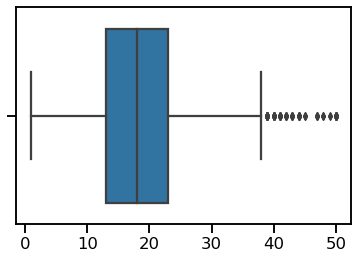

In [163]:
lens=[]
for sent in input_ids:
    largo=0
    for wd in sent:
        if wd!=0:
            largo+=1
    lens.append(largo)
    
sns.boxplot(lens)

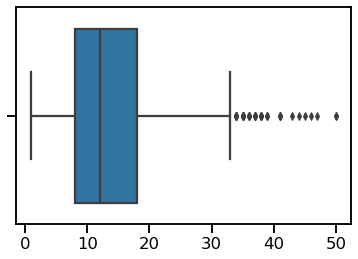

In [164]:
lens=[]
for sent in input_ids_val:
    largo=0
    for wd in sent:
        if wd!=0:
            largo+=1
    lens.append(largo)
    
sns.boxplot(lens)

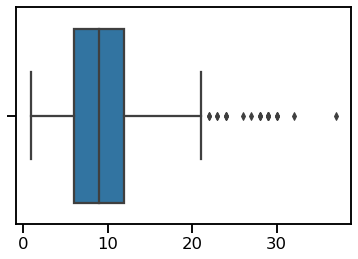

In [165]:
lens=[]
for sent in input_ids_test:
    largo=0
    for wd in sent:
        if wd!=0:
            largo+=1
    lens.append(largo)
    
sns.boxplot(lens)

In [166]:
n_in_trainNtest=set(corpus_n)-set(t_corpus_n)
n_in_testNtrain=set(t_corpus_n)-set(corpus_n)
print ("Para Non-H hay...")
print ("Training:", len(set(corpus_n)))
print ("Testing:", len(set(t_corpus_n)))
print ("Existen ",len(n_in_trainNtest),"términos en training que no están en Testing")
print ("Existen ",len(n_in_testNtrain),"términos en Testing que no están en training")
print ('')
i_in_trainNtest=set(corpus_i)-set(t_corpus_i)
i_in_testNtrain=set(t_corpus_i)-set(corpus_i)
print ("Para IndirectH hay...")
print ("Training:", len(set(corpus_i)))
print ("Testing:", len(set(t_corpus_i)))
print ("Existen ",len(i_in_trainNtest),"términos en training que no están en Testing")
print ("Existen ",len(i_in_testNtrain),"términos en Testing que no están en training")
print ('')
p_in_trainNtest=set(corpus_p)-set(t_corpus_p)
p_in_testNtrain=set(t_corpus_p)-set(corpus_p)
print ("Para PhysicalH hay...")
print ("Training:", len(set(corpus_p)))
print ("Testing:", len(set(t_corpus_p)))
print ("Existen ",len(p_in_trainNtest),"términos en training que no están en Testing")
print ("Existen ",len(p_in_testNtrain),"términos en Testing que no están en training")
print ('')
s_in_trainNtest=set(corpus_s)-set(t_corpus_s)
s_in_testNtrain=set(t_corpus_s)-set(corpus_s)
print ("Para SexualH hay...")
print ("Training:", len(set(corpus_s)))
print ("Testing:", len(set(t_corpus_s)))
print ("Existen ",len(s_in_trainNtest),"términos en training que no están en Testing")
print ("Existen ",len(s_in_testNtrain),"términos en Testing que no están en training")

Para Non-H hay...
Training: 6784
Testing: 3165
Existen  4423 términos en training que no están en Testing
Existen  804 términos en Testing que no están en training

Para IndirectH hay...
Training: 353
Testing: 88
Existen  334 términos en training que no están en Testing
Existen  69 términos en Testing que no están en training

Para PhysicalH hay...
Training: 505
Testing: 158
Existen  463 términos en training que no están en Testing
Existen  116 términos en Testing que no están en training

Para SexualH hay...
Training: 4325
Testing: 2637
Existen  2720 términos en training que no están en Testing
Existen  1032 términos en Testing que no están en training


##### VIZUALIZACION

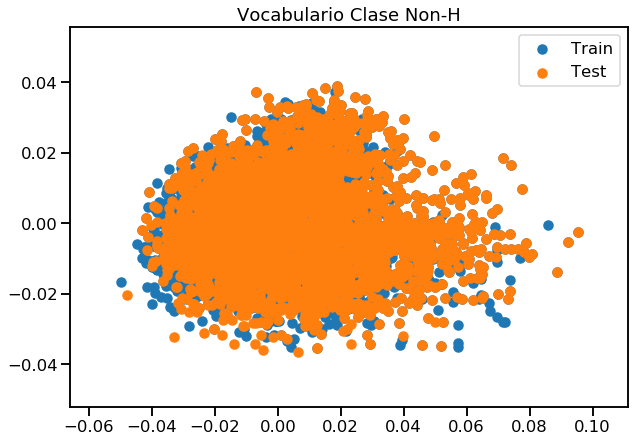

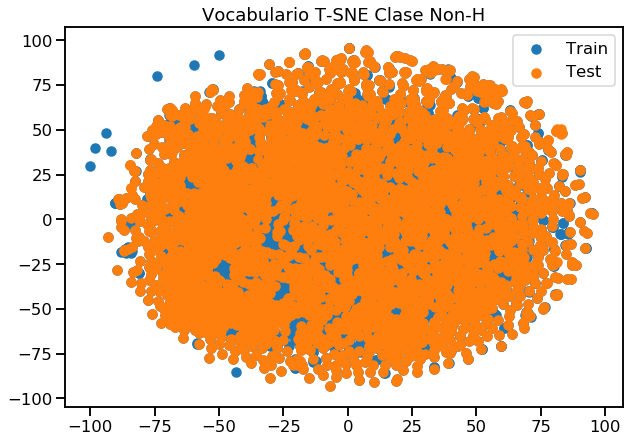

In [167]:
clase=["Train"]
labels1 = clase*len(set(corpus_n))
corpus_temp=list(set(corpus_n))
data1=[M_BERT_space[Word2Index[wd]] for wd in corpus_temp]
clase=["Test"]
labels2 = clase*len(set(t_corpus_n))
corpus_temp=list(set(t_corpus_n))
data2=[M_BERT_space[Word2Index[wd]] for wd in corpus_temp]
data=data1+data2
labels=labels1+labels2

to_plot_kpca = visualize_dims(data, np.asarray(labels), 'Non-H')
to_plot_tsne = visualize_dims_tsne(data, np.asarray(labels), 'Non-H')

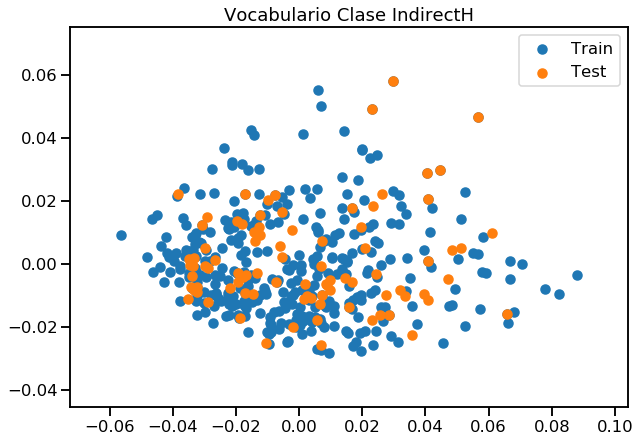

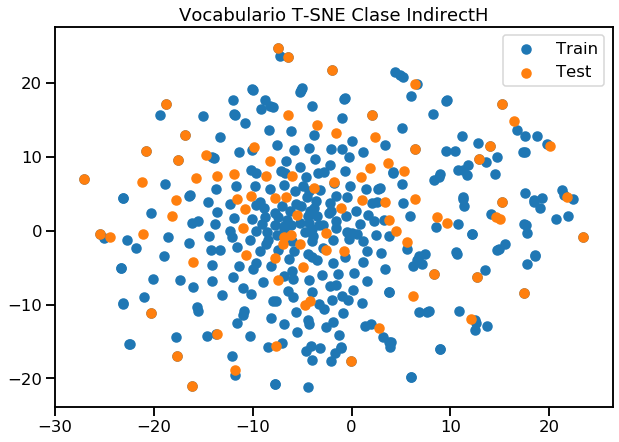

In [168]:
clase=["Train"]
labels1 = clase*len(set(corpus_i))
corpus_temp=list(set(corpus_i))
data1=[M_BERT_space[Word2Index[wd]] for wd in corpus_temp]
clase=["Test"]
labels2 = clase*len(set(t_corpus_i))
corpus_temp=list(set(t_corpus_i))
data2=[M_BERT_space[Word2Index[wd]] for wd in corpus_temp]
data=data1+data2
labels=labels1+labels2

to_plot_kpca = visualize_dims(data, np.asarray(labels), 'IndirectH')
to_plot_tsne = visualize_dims_tsne(data, np.asarray(labels), 'IndirectH')

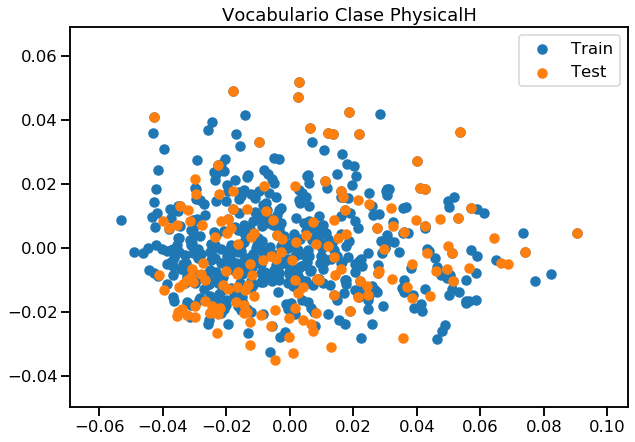

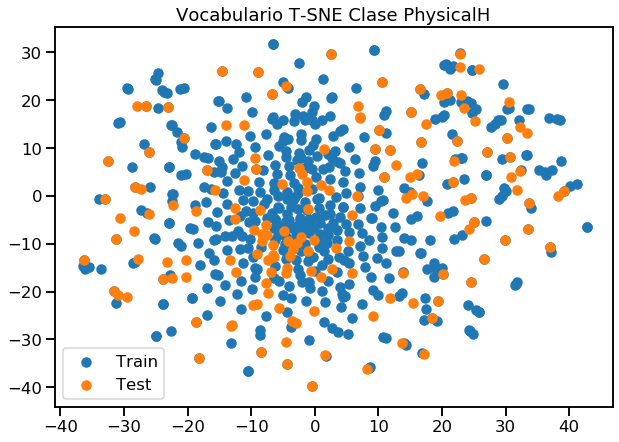

In [169]:
clase=["Train"]
labels1 = clase*len(set(corpus_p))
corpus_temp=list(set(corpus_p))
data1=[M_BERT_space[Word2Index[wd]] for wd in corpus_temp]
clase=["Test"]
labels2 = clase*len(set(t_corpus_p))
corpus_temp=list(set(t_corpus_p))
data2=[M_BERT_space[Word2Index[wd]] for wd in corpus_temp]
data=data1+data2
labels=labels1+labels2

to_plot_kpca = visualize_dims(data, np.asarray(labels), 'PhysicalH')
to_plot_tsne = visualize_dims_tsne(data, np.asarray(labels), 'PhysicalH')

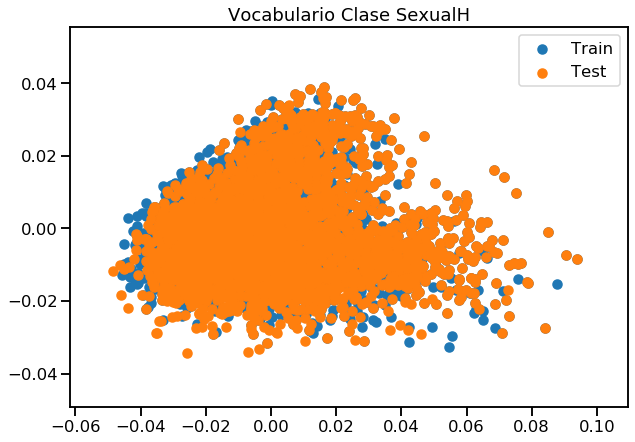

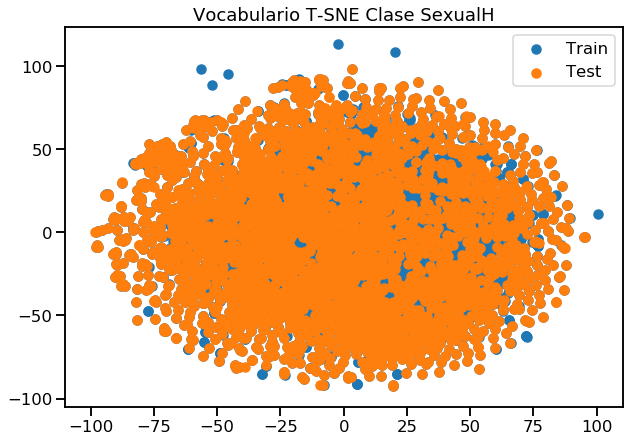

In [170]:
clase=["Train"]
labels1 = clase*len(set(corpus_s))
corpus_temp=list(set(corpus_s))
data1=[M_BERT_space[Word2Index[wd]] for wd in corpus_temp]
clase=["Test"]
labels2 = clase*len(set(t_corpus_s))
corpus_temp=list(set(t_corpus_s))
data2=[M_BERT_space[Word2Index[wd]] for wd in corpus_temp]
data=data1+data2
labels=labels1+labels2

to_plot_kpca = visualize_dims(data, np.asarray(labels), 'SexualH')
to_plot_tsne = visualize_dims_tsne(data, np.asarray(labels), 'SexualH')